# Import libraries

In [8]:
# General libraries
import numpy as np
from pyDOE import lhs
import h5py

# Parallelisation libraries
from joblib import Parallel, delayed

# Module functions
import ximinf.selection_effects as se
import ximinf.generate_sim as gsim

# Plot libraries
import matplotlib.pyplot as plt

# Generation of SN Ia samples in parallel

In [9]:
# -------- User parameters --------

N = 10_000 # Number of samples 100_000
M = 200 # Number of SNe per sample #3_000

# Range of standardisation paremeters
alpha_range = (-2, 2) # TO CHANGE FOR TWO PARAMS FOR BROKEN ALPHA #(-0.6, 0.4)
beta_range  = (1, 5) #(2.8, 3.8)
gamma_range = (-2, 2)
mabs_range = (-21, -17) #(-19.8, -18.8)

# ---------------------------------

# Sampling
unit_samples = lhs(4, samples=N) #(3, samples=N)
alpha_vals = unit_samples[:, 0] * (alpha_range[1] - alpha_range[0]) + alpha_range[0]
beta_vals  = unit_samples[:, 1] * (beta_range[1]  - beta_range[0])  + beta_range[0]
mabs_vals  = unit_samples[:, 2] * (mabs_range[1]  - mabs_range[0])  + mabs_range[0]
gamma_vals = unit_samples[:, 3] * (gamma_range[1]  - gamma_range[0])  + gamma_range[0]

# Create list of dicts, one dict per simulation
param_samples = [
    {"alpha": a, "beta": b, "mabs": m, "gamma": g}
    for a, b, m, g in zip(alpha_vals, beta_vals, mabs_vals, gamma_vals)
]

columns = ['magobs', 'magobs_err','x1', 'x1_err', 'c', 'c_err', 'prompt', 'localcolor', 'localcolor_err', 'z']
params = ['alpha', 'beta', 'mabs', 'gamma']

print("Running parallel simulations...")
results = Parallel(n_jobs=6)(
    delayed(gsim.simulate_one)(
        param_dict, sigma_int=0.15, z_max=0.2, M=M, cols=columns, N=N, i=i
    ) for i, param_dict in enumerate(param_samples)
)
print("... done")

Running parallel simulations...
... doneon 10000/10000


In [10]:
# Applying selection effect
print('Applying selection effect...')
m_lim = 19.5
simulations = se.malmquist_bias_batch(results, m_lim, M, columns)
print('...done')

Applying selection effect...
...done


# Plot the first sample

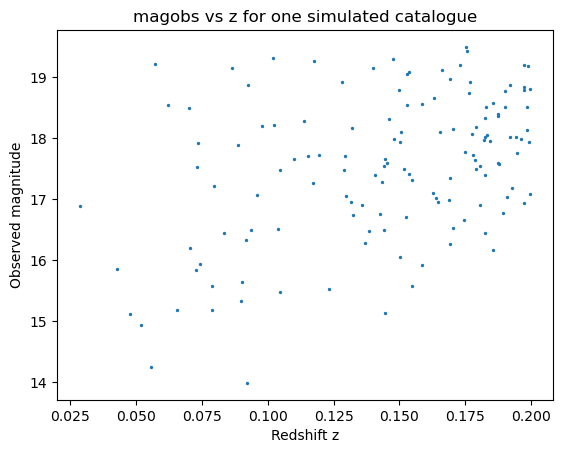

Number of SNe after selection: 136


In [11]:
# Take one simulation
example = simulations[0]

# Convert columns to NumPy arrays for easier indexing
magobs = np.array(example['data']['magobs'])
z      = np.array(example['data']['z'])

# Apply selection (magobs > 0)
mask = magobs > 0
magobs_cut = magobs[mask]
z_cut = z[mask]

# Plot
plt.figure()
plt.scatter(z_cut, magobs_cut, s=2)
plt.xlabel("Redshift z")
plt.ylabel("Observed magnitude")
plt.title("magobs vs z for one simulated catalogue")
plt.show()

# Number of SNe after selection
print('Number of SNe after selection:', len(magobs_cut))


# Save data to disk

In [12]:
# Estimate size in bytes
total_bytes = 0
for sim in simulations:
    # Data: sum of lengths of all columns
    for col_values in sim['data'].values():
        total_bytes += len(col_values) * 4  # 4 bytes per float32
    # Params: assume float64 (8 bytes) per parameter
    total_bytes += len(sim['params']) * 8

size_MB = total_bytes / (1024**2)
print(f"Estimated size on disk: {size_MB:.2f} MB")

Estimated size on disk: 76.60 MB


In [13]:
save_path = "../data/SIM/simulations.h5"
with h5py.File(save_path, "w") as f:
    for i, sim in enumerate(simulations):
        grp = f.create_group(f"sim_{i}")
        # Save parameters
        for key, val in sim["params"].items():
            grp.attrs[key] = val
        # Save data
        data_grp = grp.create_group("data")
        for col, arr in sim["data"].items():
            data_grp.create_dataset(col, data=np.array(arr, dtype=np.float32))